# Lecture 7 - Assembly, quality assessment, and predictions I

The purpose of this tutorial is to continue exploring genome assemblies and the effect of read depth and error rates in the contiguity of assemblies. That section of the tutorial will use an assembly genome to simulate Illumina reads at three coverage depths and two error rates. Using the simulated reads, you will have to use loops and scripts to assemble the genomes.

The second part of the tutorial deals with the quality assessment of the genomes assemblied, both using qualitative and quantitative estimates. One of the quality assessment metrics is estimated by comparing a reference genome and all the assemblies generated.

The last part of the tutorial is an introduction to methods for feature prediction using hidden Markov models, just like BUSCO uses them (we will look into BUSCO during the next tutorial). You will predict which proteins of the fish transcriptome (same species as previous tutorials) are globin proteins.

---

## 1. Setting up the environment

As always, we need to create an environment with the packages we will use throughout the tutorial.

### 1.1. Sequence simulation and assembly environment

In [ ]:
%%bash

# update conda
conda update -n base conda

# creating environment
conda create -n reseq -c bioconda reseq
conda activate reseq
conda install -c bioconda minimap2 spades samtools
conda install -c bioconda agb
conda install -c biocore hmmer
conda install -c bioconda mafft
conda install -c bioconda quast
conda install -c conda-forge -c bioconda busco=5.5.0

cd ~;

# if you forgot how to get the file and don't have it in your computer:
wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.6/sratoolkit.3.0.6-ubuntu64.tar.gz
tar xvzf sratoolkit.3.0.6-ubuntu64.tar.gz

# continue here if you already have sratoolkit
cd ~
cd sratoolkit.3.0.6-ubuntu64/bin/;
FASTDUMP="$PWD/fastq-dump";
echo $FASTDUMP;

# check
$FASTDUMP --help

### 1.2 Download the data

Get the bacterial reference genome and the reads for the same bacterial strain, both of which we will use to simmulate Illumina reads. We are using data from [*Borrelia burgdorferi*](https://en.wikipedia.org/wiki/Borrelia_burgdorferi), one of the agents behind [Lyme disease](https://en.wikipedia.org/wiki/Lyme_disease).

In [ ]:
%%bash

# go back to your working directory
# Illumina WGS of Borrelia burgdorferi: isolated from Ixodes pacificus in Western Canada

$FASTDUMP --split-3 SRR25420533

# get a reference genome for a linear chromosome bacteria
# Borreliella burgdorferi Bol26
# Borreliella burgdorferi bol26 is a strain of Lyme disease spirochete (Borreliella burgdorferi).

wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/181/575/GCF_000181575.2_ASM18157v2/GCF_000181575.2_ASM18157v2_genomic.fna.gz

conda activate reseq

gunzip GCF_000181575.2_ASM18157v2_genomic.fna.gz

# if gunzip doesn't work, try:

gzip -d GCF_000181575.2_ASM18157v2_genomic.fna.gz

---

## 2. Simulating Illumina reads from a reference genome and other Illumina data

### 2.1. Selecting a single chromosome as the reference

Before simulating the data, let's have a look at the reference genome and select the longest linear chromosome we can find.

<div class="alert alert-block alert-success">
<b>TO DO: </b>How many sequences are there in the <i>fna</i> file? From the information in the header, how manny of the contigs are plasmids? How many are "gcontigs"? Append you answer to your <i>answersL7_name.txt</i></div>

Solution hidden here

<!--
grep '>' GCF_000181575.2_ASM18157v2_genomic.fna | wc -l
grep 'plasmid' GCF_000181575.2_ASM18157v2_genomic.fna | wc -l
grep 'gcontig' GCF_000181575.2_ASM18157v2_genomic.fna | wc -l

How many sequences?  20
how many plasmids? 16
how many gcontigs? 16
    --> 

To easily select the longest contig, we first need to linearise the sequence. Then, we can count the number of characters in the sequence and create a file with the one that happens to be the longest.

In [ ]:
%%bash

# Linearise the sequence
awk '/^>/ { if(NR>1) print "";  printf("%s\n",$0); next; } { printf("%s",$0);}  END {printf("\n");}' < GCF_000181575.2_ASM18157v2_genomic.fna > GCF_000181575_SL.fna

# use grep to select the contigs only
grep -A 1 'gcontig' GCF_000181575_SL.fna > GCF_000181575_contigs.fna

# count sequence characters and check which chromosome is larger
awk '/^>/{if (l!="") print l; print; l=0; next} {l+=length($0)} END {print l}' GCF_000181575_contigs.fna

<div class="alert alert-block alert-success">
<b>TO DO: </b>Use grep and grep arguments to create a file containing only the longest contig. The name of the file must be <i>GCF_000181575_contiglongest.fna</i>. <b>You will need this file to continue</b></div>

Solution hidden here

<!--
grep -A1 'gcontig_1118719648276' GCF_000181575_contigs.fna > GCF_000181575_contiglongest.fna
-->


### 2.2. Mapping real Illumina reads to the reference

This step creates an alignment BAM file. The program will use the alignment to derive metrics that allow for the simmulation of realistic Illumina reads.

In [ ]:
%%bash

# mapping illumina reads before cleaning to get simulations closest to real data
minimap2 -t 4 -x sr GCF_000181575_contiglongest.fna SRR25420533_1.fastq SRR25420533_2.fastq -a | samtools sort -@ 4 -o SRR25420533.bam -

# check that the BAM file is not truncated
samtools view SRR25420533.bam | tail

### 2.3. Simulating Illumina reads

We are using [ReSeq](https://github.com/schmeing/ReSeq) by [Schmeing and Robinson (2021)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02265-7) to create realistic Illumina reads given an expected read depth and an error rate. The aim of simmulating reads under different scenarios and assembling those reads to check the quality of the assemblies, is to understand the effect of read depth and error rate in the length of the assembled contigs and the possibility of creating [chimeras](https://en.wikipedia.org/wiki/Chimera_(mythology)). The idea being that, understanding how things break, we can fix broken things.

Simmulating the reads will take a while and some disk space. Each student can choose one read depth and simulate the reads using two error rate values:

In [ ]:
%%bash

# expected read-depth = 5
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim5error1_1.fastq -2 sim5error1_2.fastq -c 5 --errorMutliplier 1 --seed 666
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim5error3_1.fastq -2 sim5error3_2.fastq -c 5 --errorMutliplier 3 --seed 666;

# expected read-depth = 10
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim10error1_1.fastq -2 sim10error1_2.fastq -c 10 --errorMutliplier 1 --seed 666
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim10error3_1.fastq -2 sim10error3_2.fastq -c 10 --errorMutliplier 3 --seed 666;

# expected read-depth = 20
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim20error1_1.fastq -2 sim20error1_2.fastq -c 20 --errorMutliplier 1 --seed 666
reseq illuminaPE -b SRR25420533.bam -r GCF_000181575_contiglongest.fna -1 sim20error3_1.fastq -2 sim20error3_2.fastq -c 20 --errorMutliplier 3 --seed 666

---

## 3. Draft genome assembly

By now, you are already familiar with the process of genome assembly. Not only have you assembled the fish genomes from previous practicals but you also understand what is behind short and long-read based assemblies using De Bruijn graphs or Overlap Layout Consensus.

Since you have to assemble two sets of simulated reads, with error rate multiplier one or three, you can write a script that assembles the genome by indicating the input and output files. You can use the [bash positional parameters variables](https://linuxcommand.org/lc3_wss0120.php) we saw in Lecture 2.

In [ ]:
%%bash

# assembling a single genome would be like this:
# spades can use multiple kmer sizes at the same time
# but for time and space purposes, let's only use kmer size = 77

spades.py -k 77 -t 4 \
    --pe1-1 forward_reads.fastq --pe1-2 reverse_reads.fastq \
    --only-assembler -o output_folder

<div class="alert alert-block alert-success">
<b>TO DO: </b>Create a script to assemble the two read datasets you have. Use Bash's positional parameters. Call your script <i>assemble.sh</i>. Don't forget that the very first line needs to tell the prompt which language you are using. You also need to change the permission of the file to allow execution.</div>

Solution hidden here

<!--
# first, create the file using nano:
nano assemble.sh

# now, write the script. The first line starts with a hashtag and the location to the language you will use
# other lines starting with a hashtag are comments

#!/usr/bin/bash

# forward reads
# reverse reads
# output prefix

# execute as ./assemble.sh read_1.fastq read_2.fastq test

echo "forward ${1}"
echo "reverse ${2}"

spades.py -k 77 -t 4 \
    --pe1-1 $1 --pe1-2 $2 \
    --only-assembler -o "${3}"
# now, change permissions for the file
chmod 777 assemble.sh


echo 'done'

-->

Now, you should be able to launch a loop to run your script!

In [ ]:
%%bash

# this loop is for running the assembly for ALL datasets (three read depth values X two error rates)

for cov in 5 10 20; do
    ./assemble.sh sim${cov}error1_1.fastq sim${cov}error1_2.fastq sim${cov}error1_out
    ./assemble.sh sim${cov}error3_1.fastq sim${cov}error3_2.fastq sim${cov}error3_out
done

# modify the loop to make it useful for the two files you need to run.

SPAdes generates files for the De Bruijn graphs. Visualising the graphs can be tricky for very large genomes, but ours are small and we can give it a try. A classic piece of software for graph visualisation is [Bandage](https://rrwick.github.io/Bandage/). Go to the website and download the program that suits your machine's operative system (if you have a Windows, download the distribution for Windows. We are not going to use it through our Linux subsystem)

Install it. Run it. You need to load the graph first: **File > Load graph**. Then, in the pannel to the left, you can find information about the grpah, the number of nodes (Nodes) and links (Edges). Then, you have the option of **Draw graph**. You need to click that button before the graph is shown. Play around with the options and visualise both of your graphs.

<div class="alert alert-block alert-success">
<b>TO DO: </b>What is the effect of read depth in the number of unplaced contigs? And in the complexity of the graph? what is the effect of error rates and how error rate and read depth interact? Append you answer to your <i>answersL7_name.txt</i> If you don't have enough space in your computer and cannot play around with all the assemblies, you can have a look at the different graphs in Lecture 6</div>

---

## 4. Quallity assessment

This part of the tutorial will go through different quality metrics estimated with [Quast](https://github.com/ablab/quast) and [BUSCO]().

Quast ([Mikheenko et al., (2018)](https://academic.oup.com/bioinformatics/article/34/13/i142/5045727)) is a tool developed for quality assessment of assemblies with the capability to compare different assemblies at once if they are generated from the same reads (i.e. compares assemblies of the same data but generated differently). Making choices about *kmer* sizes or other assembly-related arguments is tough without knowing what the genome should look like in real life (we don't know the ground truth more often than not). Thus, being able to compare different assembly strategies is key. Quast takes the assemblies and reference sequences when available, and computes the theoretical features of the genome (size, complexity, etc) to estimate how close each of the *de novo* assemblies being evaluated are to the reference. We don't always have the reference genome to compare against, in which case Quast still provides a set of metrics that are indicative of the quality of the assemblies.



In [ ]:
%%bash

# let's run quast for the assemblies generated from the simulated Illumina reads
# using the original reads, not the simulated ones
# this is theory not correct (compare only assemblies from the same reads!) 
# but we will let it pass as the reads are simulated from the same data sample
quast.py $(ls *out/scaffolds.fasta) \
        -r GCF_000181575_contiglongest.fna \
        --memory-efficient --space-efficient --k-mer-stats -f --x-for-Nx 50 \
        -1 SRR25420533_1.fastq -2 SRR25420533_2.fastq \
        -o quast_out

Have a look at the summary results!!!

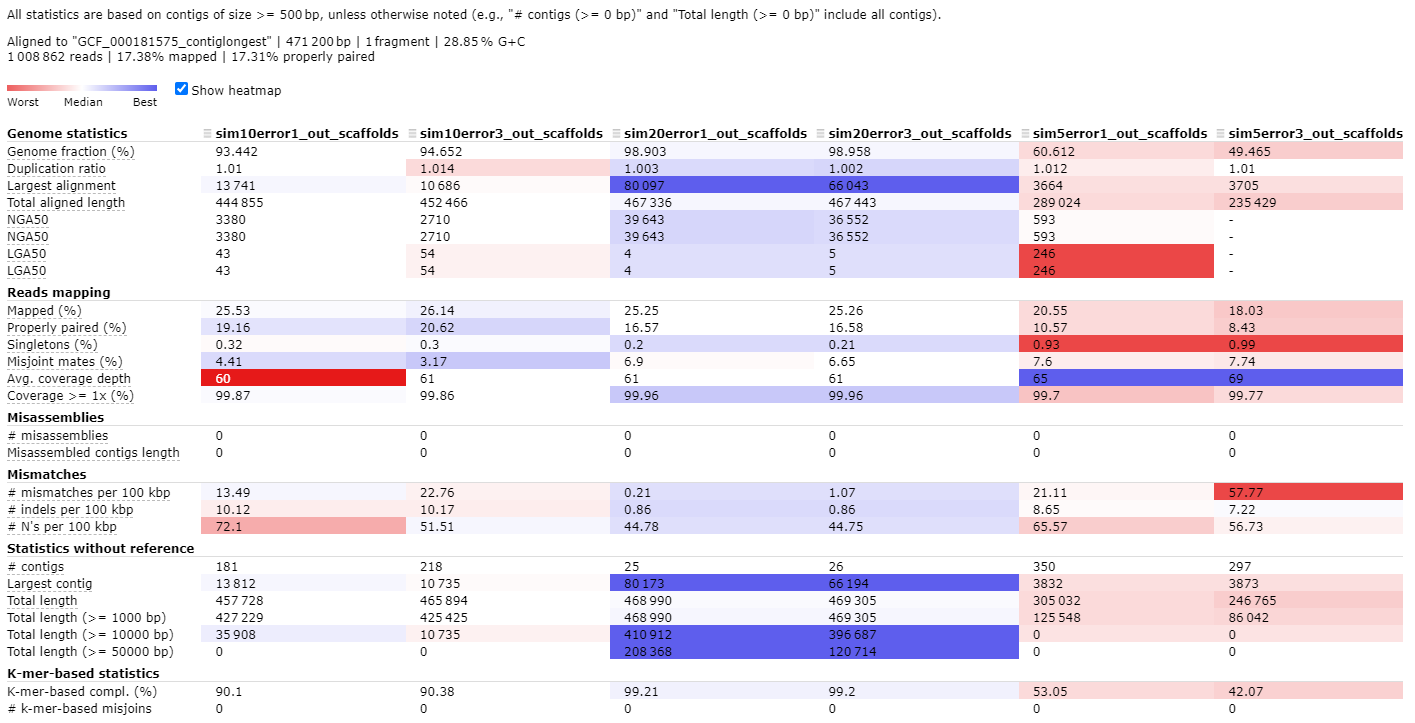

Let's look at some of the metrics.

Average coverage depth (read depth) and coverage are not what we simulated from the reads. That is because we used the original set of Illumina reads to generate the metrics (due to time). 

<div class="alert alert-block alert-success">
<b>TO DO: </b>Run Quast for your assemblies and your simulated reads. Compare the results between your samples (low and high error rates) and with the report we generated above. Append you answer to your <i>answersL7_name.txt</i></div>

We can estimate genome statistics when we have a reference genome to compare the assemblies to, with the caveat that the reference genome might or might not be the ground truth. 

**Genome statistics include:**

**Genome fraction:** Equivalent to genome coverage. It is the percentage of the reference genome covered by contigs aligned to it. A site is consireded covered if at least one base in a contig can align to it. Contigs that map to the reference multiple times are counted multiple times, meaning that genomes with high content of repetitive regions might have a high genome fraction just because the repetitive contigs are mapping to all the repetitive regions.

**Largest alignment and largest contig:** The largest alignment is the longest continuous alignment between a contig and the reference. Because it is meant to be continuous, it necesarely needs to be as long as the largest contig, unless there is mismatches within the alignment. When the largest alignment is shorter than the largest contig, we can suspect misalingments or chimeric assemblies.

**NGA50 and LGA50:** To understand these metrics, we first need to understand N50, L50, NG50, and LG50. **N50** is a metric for contiguity and it is defined as the sequence length of the shortest contig at 50% of the total assembly length. It can be thought as the median contiguity: after ordering contigs by length, from long to short, it is the *length of the contig* such that 50% of the entire assembly is contained in the contigs equal and longer than that value. **L50** is the *count of contigs*, from long to short, whose length sum makes 50% of the assembly. A limitation of N50 and L50 (or similar NX and LX metrics) is the dependance on assembly size and the assumption that the assembly size is already correct. That is not always true (in fact, it is rarely true). **NG50** and **LG50**, instead of using the 50% of the whole assembly as reference, it uses the 50% of the known or estimated genome size, often through flow cytometry, karyotypes, and *kmer*-based genome size estimation. Unlike N50 and L50, NG50 and LG50 are comparable across assemblies. Now, **NGA50** and **LGA50** take the metrics further by considering only the alligned part of the contig, not the contig. To calculate both, `Quast` first check the alignment between a contig and the reference, assuming that correctly assembled contigs must match and align perfectly to the reference. If the contig has a mismatch caused by a misassembly, it breaks the contig into smaller contigs at the mismatch. After breaking down contigs with mismatches, it calculates NG50 and LG50.

Figure by [DariaGorbacheva, Wikimedia commons](https://commons.wikimedia.org/wiki/File:Genome_Assembly_Statistics.png), **The simple example of counting N50, L50, N90, D50 statistics.**
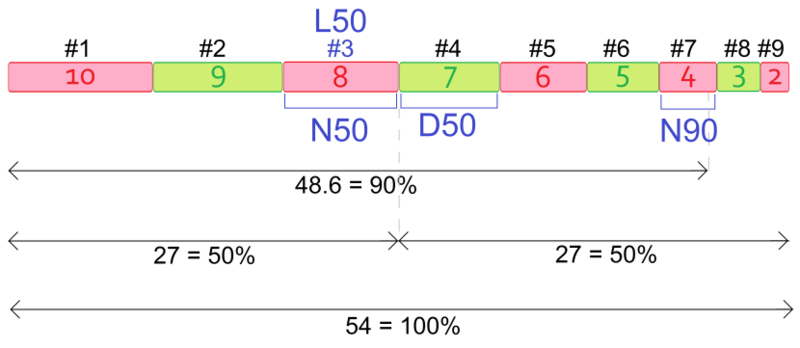


**Missassembled contig length:** Is the total number of bases in contigs that have one ore more mismatches to the reference.

**Total length (>= X bp):** Is the number of bases in the assembly after removing contigs shorter than X bp. This metric does not rely on a reference genome.

Other metrics reported by `Quast` are intuitive and must be interpreted jointly. In addition, `Quast` generates dynamic plots to explore NX, NGX, and NGAX metrics.

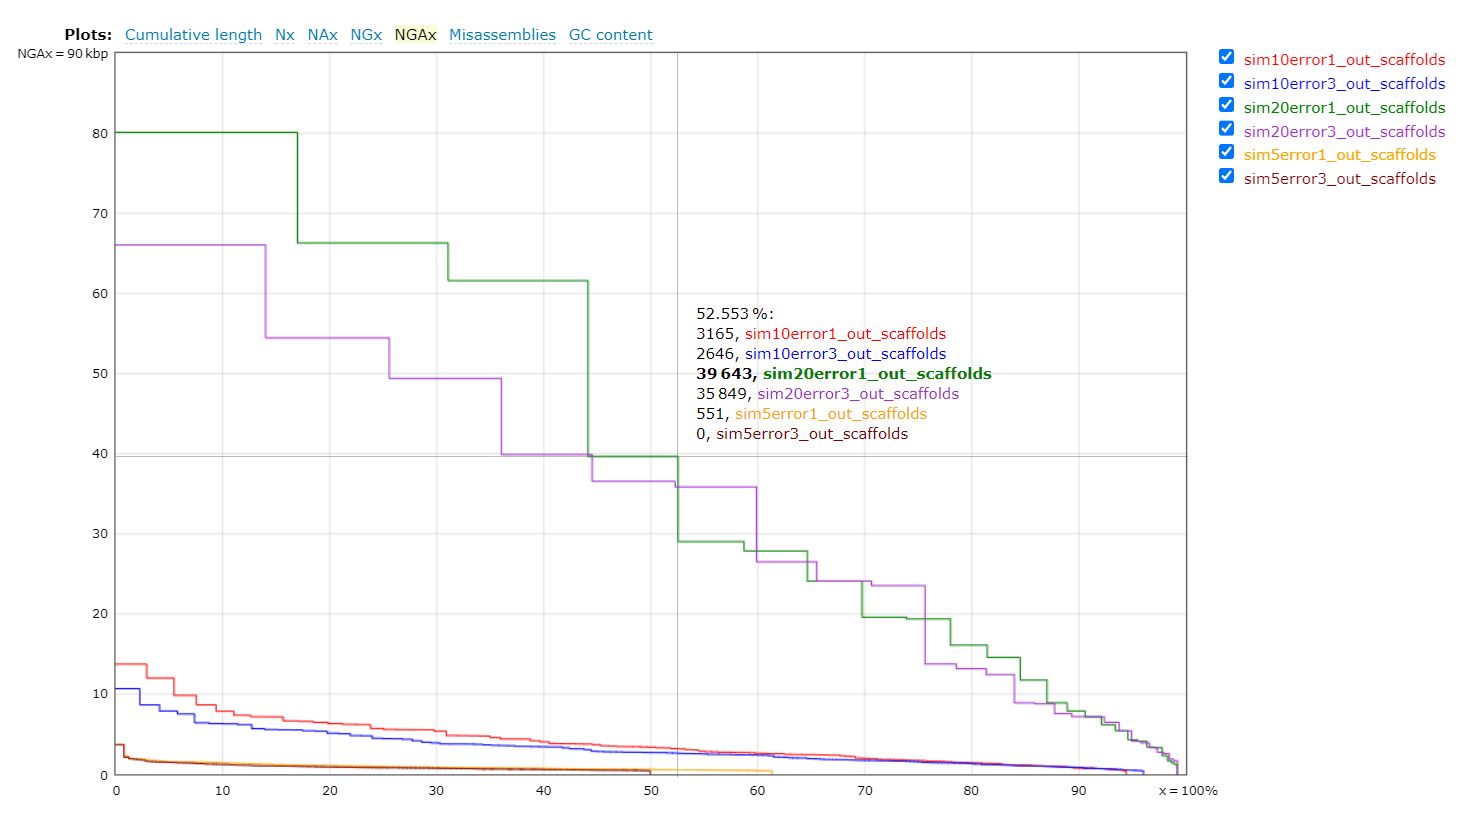

In [ ]:
%%bash



---
## 5. Using HMMER to build profiles and predict features

[HMMER](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/http://eddylab.org/software/hmmer/Userguide.pdf) is a package of tools for creating models (also known as profiles) of protein sequences based on context, observed data, and data states that we cannot observe (they are hidden). A common application of the models ([Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model)) is, for example, the prediction of a protein-coding gene in the genome of a non-model organism. Scientists have dedicated decades of research and resources to understand deeply the biology and evolution of a handful of model organisms - like Ecoli, zebra fish, *Drosophila* flies, or *Arabidopsis* plants -  and to create datasets that we can use to build approximations to these processes in other organisms. So, for predicting protein-coding genes in, e.g. a fish endemic to the lakes in Žemaitija, we can leverage the **protein coding gene sequences observed** in the zebra fish to build models that account for **the hidden processess driving evolution** in the endemic fish and predict which sequences in the endemic fish's genome are more likely to code for proteins.

In this exercise, we will create profiles of [globin](https://en.wikipedia.org/wiki/Globin) protein sequences to predict which of the protein sequences of the fish' transcriptome is a globin protein. Globin proteins are involved in binding and transporting oxygen and can be divided into three main lineages present in most organisms, with hemoglobin and myoglobin being key for the survival of most animals. Globins are characterised by a globin fold that allows the binding of an iron-containing molecule that is responsible for the reversible binding of oxygen. That fold is highly conserved across the tree of life, although the sequences forming the fold can diverge significantly.

Hemoglobins and myoglobins are present in fish, and their genes might have evolved to meet their specific oxygen-carrying and storage needs. For example, some fish species may have specialized hemoglobins that allow them to live in low-oxygen environments or deep-sea conditions.

To be able to predict globins in the fish transcriptomes, we first need to create a profile using globin protein sequences known to exist in [Osteichthyes (bony fishes)](https://en.wikipedia.org/wiki/Osteichthyes). For this, we will download globin protein sequences from Osteichthyes to create a **multiple sequence alignment (MSA)**. [MAFFT](https://mafft.cbrc.jp/alignment/software/algorithms/algorithms.html) is a standard alignment tool with several algorithms to account for sequence divergence, sequence length, and sequence number.

If you wanted to predict nucleotide features, you need to create profiles from nucleotide data.

In [ ]:
%%bash

# download the amino acid sequences
# we are not using the nucleotide sequences from the nucleotide database because they are not delimited, resulting in the download of whole chromosomes
# we are limiting the search further because of file size and time
esearch -db protein -query "globin[All Fields] AND Tetraodontidae[Organism] AND RefSeq[All Fields]" | efetch -format fasta > globins_osteichthyes.faa;

# How many sequences were downloaded?
# 10 sequences.
grep '>' globins_osteichthyes.faa | wc -l

# we need to use an aligning algorithm that is appropriate for sequences that can be divergent but still homologous
# you should be prioritising accuracy over time (using for example --globalpair)
# but for today's practice and time, we will use --genafpair
# and maxiterate of 100 instead of 1000

mafft --help
mafft --maxiterate 100 --genafpair globins_osteichthyes.faa > globins_osteichthyes.faa.aln

Now we use `hmmbuild` for building the profile and `hmmsearch` to predict globin proteins in the Fish' transcriptome:

In [ ]:
%%bash

hmmbuild -h

# using the fast model construction strategy but make sure you choose
# the appropriate model for your project
# wpb is the default relative sequence weighting strategy
# the last two arguments are input and output
hmmbuild --amino -o seqdump.log --fast \
         --wpb --seed 666 globins_osteichthyes.out globins_osteichthyes.faa.aln

# have a look at globins_osteichthyes.out
less globins_osteichthyes.out

hmmsearch -h

# the last two arguments are the hmmr profile created and the fasta to predict genes on
hmmsearch -o globins_predicted.log -A globins_hits.aln --notextw \
          --tblout globins_hits.txt -T 0 \
          globins_osteichthyes.out Takifugu_rubripes.fTakRub1.2.pep.all.fa

Another approach to create the profile is by **1)** choosing a seed sequence that represent the gene/feature we are interested in, then **2)** running a [PSI-BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE_TYPE=BlastSearch&PROGRAM=blastp&BLAST_PROGRAMS=psiBlast) (Position-Specific Iterated BLAST) to find closely related homologues of the chosen sequence, and **3)** downloading the alignment resulting from the position-specific blast.

You can comfortably do this by hand:

1) Go to [NCBI](https://www.ncbi.nlm.nih.gov/) and search "globin[All Fields] AND Osteichthyes[Organism]". In the database menu (left to the searching bar) you need to select "**Identical Protein Groups**". The idea is to fetch sequences representative of homologous groups, to avoid redundancy. We are also using proteins to avoid including introns and other non-coding features in the profiles that we will use for the prediction. **Remember:** you predict what you use. Hit **SEARCH** and once you are redirected to the results' page, in the filters to the left of the page, select both "**Vertebrates**" and "**RefSeq**". Choose the first result (hemoglobin, beta adult 2 -  Includes three sequences). Then click in either of the "protein accession" from RefSeq (for example, [NP_001003431.2](https://www.ncbi.nlm.nih.gov/protein/NP_001003431.2)). Once you are re-directed to the sequence's page, select "**run BLAST**" in the right menu.

---

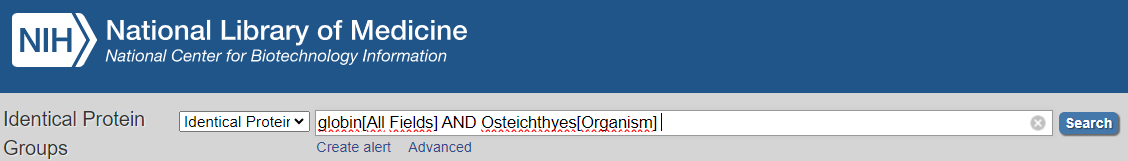

---

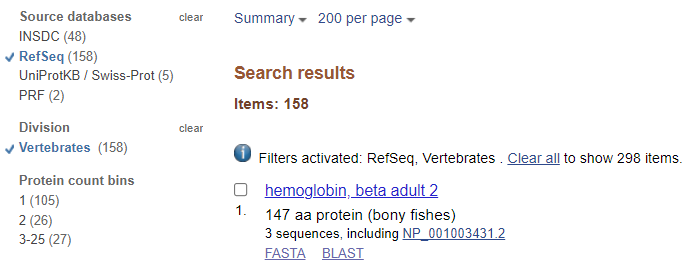

---

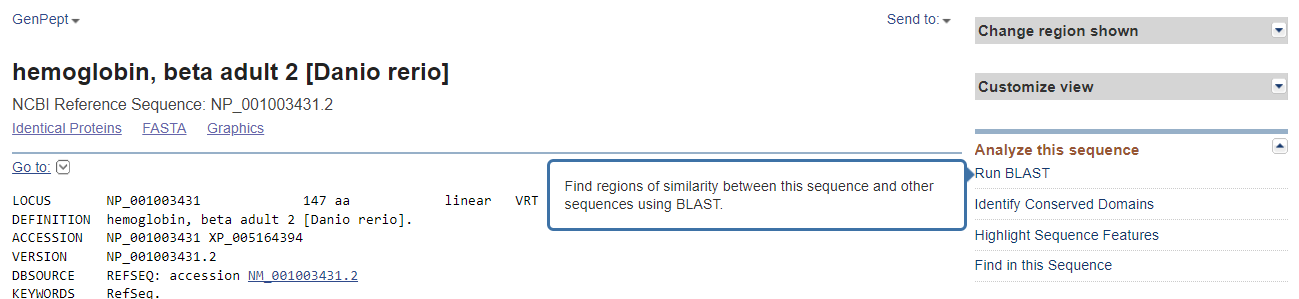

---

2) Once you are redirected to the **blastp** site, scroll down to "**Program selection**" and choose "**PSI-BLAST**", then blast. Select all 500 sequences (by default they are already selected). You can choose to run a second iteration of PSI-BLAST if you want to capture even more of the protein diversity for creating your profile, just set yourself a threshold of sequence percentage of identity below which you will not include sequences. For now, we will only use these 500 sequences.

3)  In the menu right above the sequence list, select "**Download**" then "**FASTA (aligned sequences)**". The file will download to your Downloads folder. It will be called `seqdump.txt` and it contains the 500 protein sequences but **only the parts that aligned to your query** (you still need to do the sequence alignment). **Move the file to your working directory.**

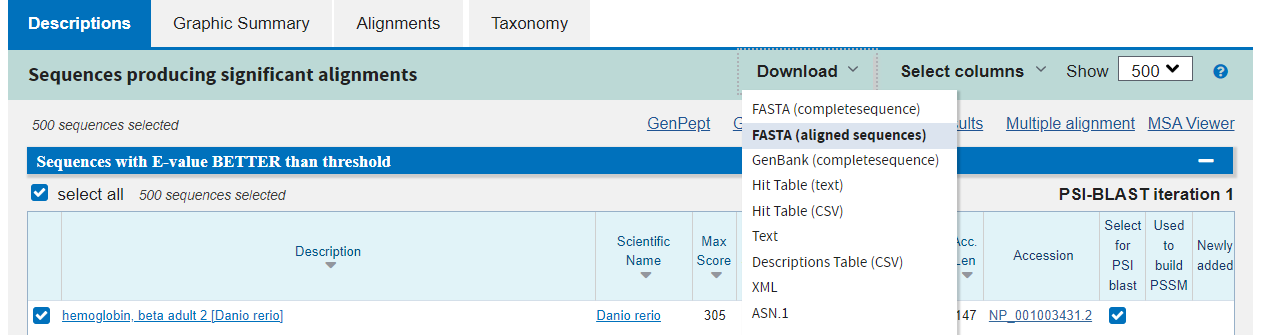


In [ ]:
%%bash

mafft --maxiterate 100 --genafpair seqdump.txt > seqdump.txt.aln

Now that we have the alignment, we can proceed to build the profile using `hmmer`

In [ ]:
%%bash

hmmbuild -h

# using the fast model construction strategy but make sure you choose
# the appropriate model for your project
# wpb is the default relative sequence weighting strategy
# the last two arguments are input and output
hmmbuild --amino -o seqdump.log --fast \
         --wpb --seed 666 seqdump_hmmer.out seqdump.txt.aln

Have a look at `seqdump_hmmer.out` and `seqdump.log`. The first file is the profile generated from a multiple sequence alignment and it is used by `hmmsearch` to search patterns that fit the profile in your set of target sequences (which become a hit sequence if the sequence has a domain predicted)

---

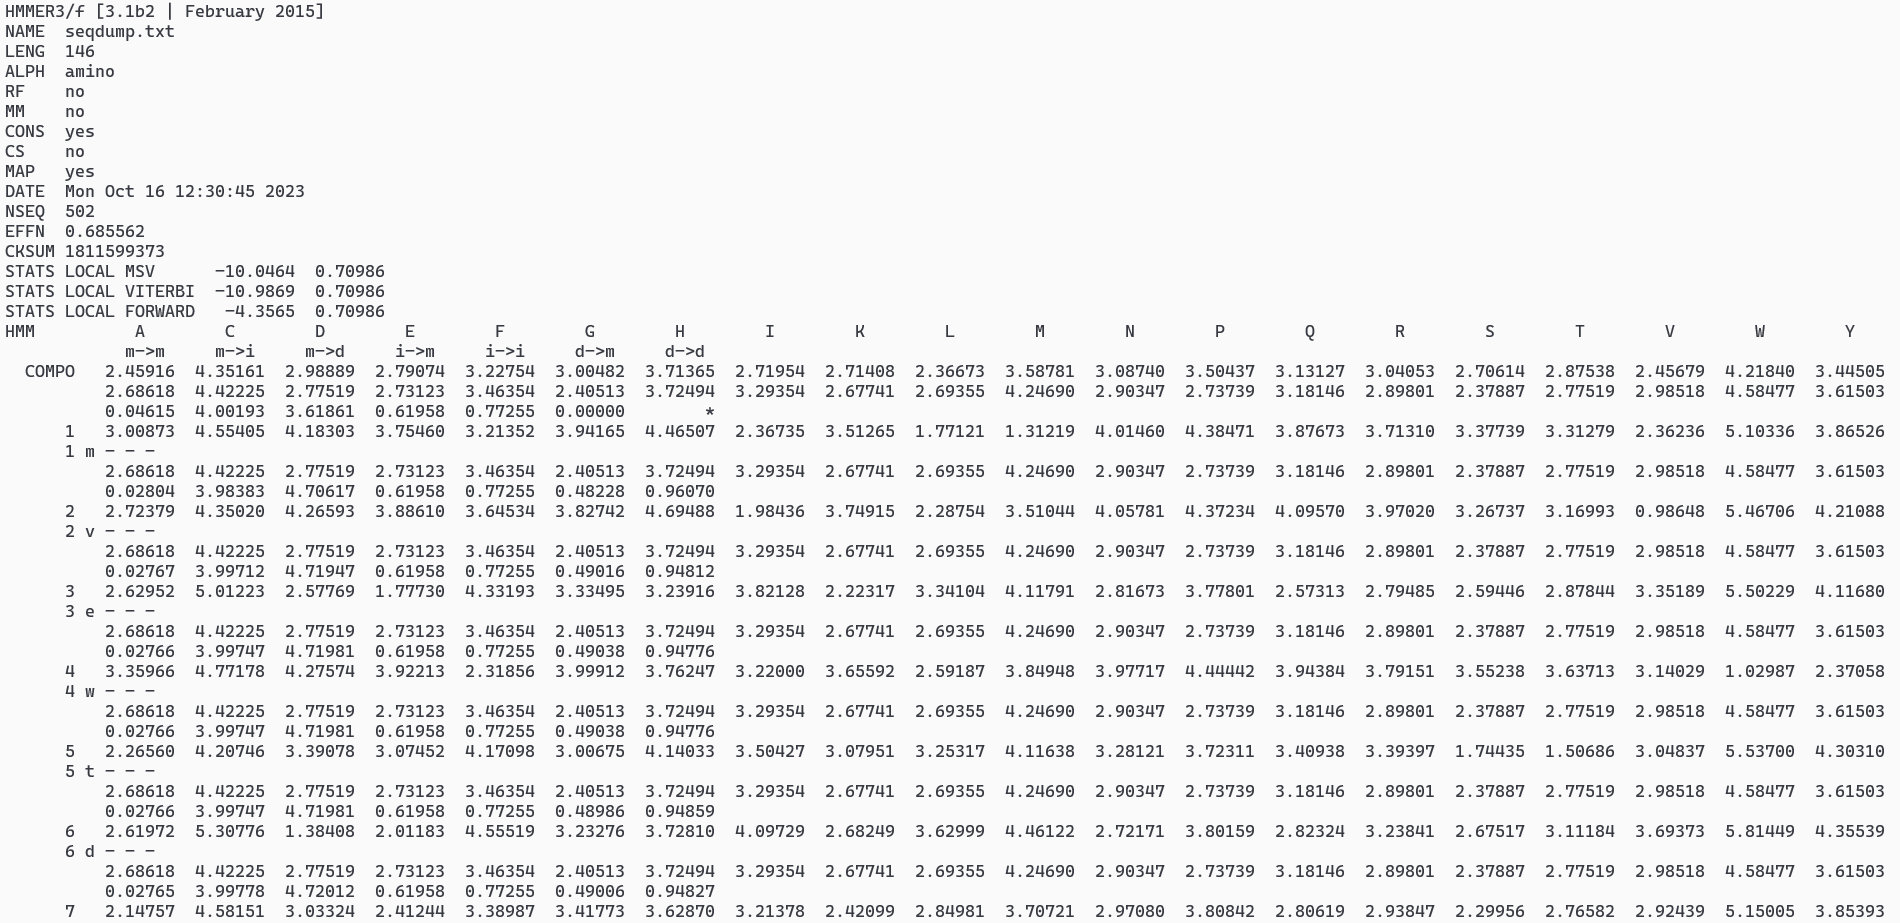

---

The second file contains information about the similarity between sequences used for building the profile (**effective sequence number** or `eff_nseq`) and the information content in the alignment (**relative entropy per position** or `re/pos`). A high effective sequence number means there is a high number of independent sequences that the model can use to get information from. Think of it as the number of "independent data points to build a profile". Sequences that are very closely related, based on their phylogeny, are less independent (there is a joint recent evolutionary process acting on them).

---

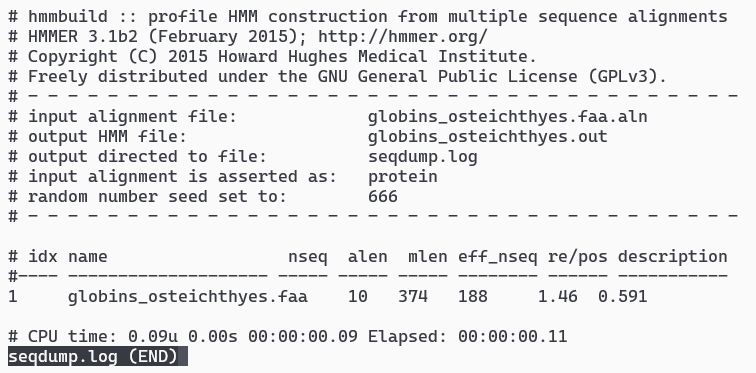

---

You can use PSI-BLAST and other blast+ algorithms to include less or more sequence diversity (and information/freedom) and achieve more or less conservative predictions. If you are strict, you might miss homologues that are distant but homologues nevertheless (and you might miss some cool discoveries). If you are too relaxed, then you might be comparing pears and apples (though botanically, those are two "species" from the same family of plants :D ).

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which profile has higher effective sequence numer and relative entropy? Append you answer to your <i>answersL7_name.txt</i></div>

The next step is to use the profile we created to search for more globin-coding genes in the fish' transcriptome data. Why? Because we are predicting amino acids.

https://ftp.ensembl.org/pub/release-110/fasta/takifugu_rubripes/pep/

In [ ]:
%%bash

hmmsearch -h

# the last two arguments are the hmmr profile created and the fasta to predict genes on
hmmsearch -o fTakRub1_predicted.log -A fTakRub1_hits.aln --notextw \
          --tblout fTakRub1_hits.txt -T 0 \
          seqdump_hmmer.out Takifugu_rubripes.fTakRub1.2.pep.all.fa

<div class="alert alert-block alert-success">
<b>TO DO: </b>Which profile was able to predict more features? Any guesses as for why? Add you answers to <i>answersL7_name.txt</i></div>

Let's look at the searching output and the meaning of the columns. The first couple of lines are the header, data, and commands used to run hmmr. Then, we have a table with the hits produced by searching multiple sequences (each a contig representing a transcript from the fish) using the profile we created from globin protein sequences.

The image below shows only one hit of the multiple hits we found. The first column indicates the **e-value**, which can be interpreted like the e-value from blast+: the smaller the better and depends on the size of the database. Then we have the **bit score**, also interpreted like the bitscore in blast+, the larger the better; it is independent from the size of the database and comparable between databases. Then we have the **bias**, which is a correction applied to the bit score when there is biased sequence composition. The bias should be small. A bias that has the same magnitude as the bit score can be a bad sign, indicating that bias correction is too aggresive and `hmmsearch` is missing homologous sequences (the bias is penalising the score of potential homologues). If it is consistently small or non-existent, means that the bias correction is not aggresive enough and the hit sequences are potentially not homologous. **Those first three columns** correspond to the mean across all domains within a hit sequence.

The next three columns correspond to the stats of the best domain found in the hit sequence. `hmmr` is trained to look for multiple protein domains when the training data for creating the profile contain multiple domains. When the e-value of the sequence hit and the best domain are significant, then the hit sequence is very likely to be homologous to the query profile. If only the e-value for the whole sequence is significant and the e-value for the best domain is not, then the hit is either a remote homologue or the sequence has low-complexity and results in hits by chance (i.e. is repetitive).

The following two columns are the **expected** and **observed** number of domains. These numbers should be very similar, if not, then it is another sign that the hit sequence might be very repetitive. finally, you have the columns with the target sequence name (truncated from the header on your transcriptome) and its description (the rest of the header)



---


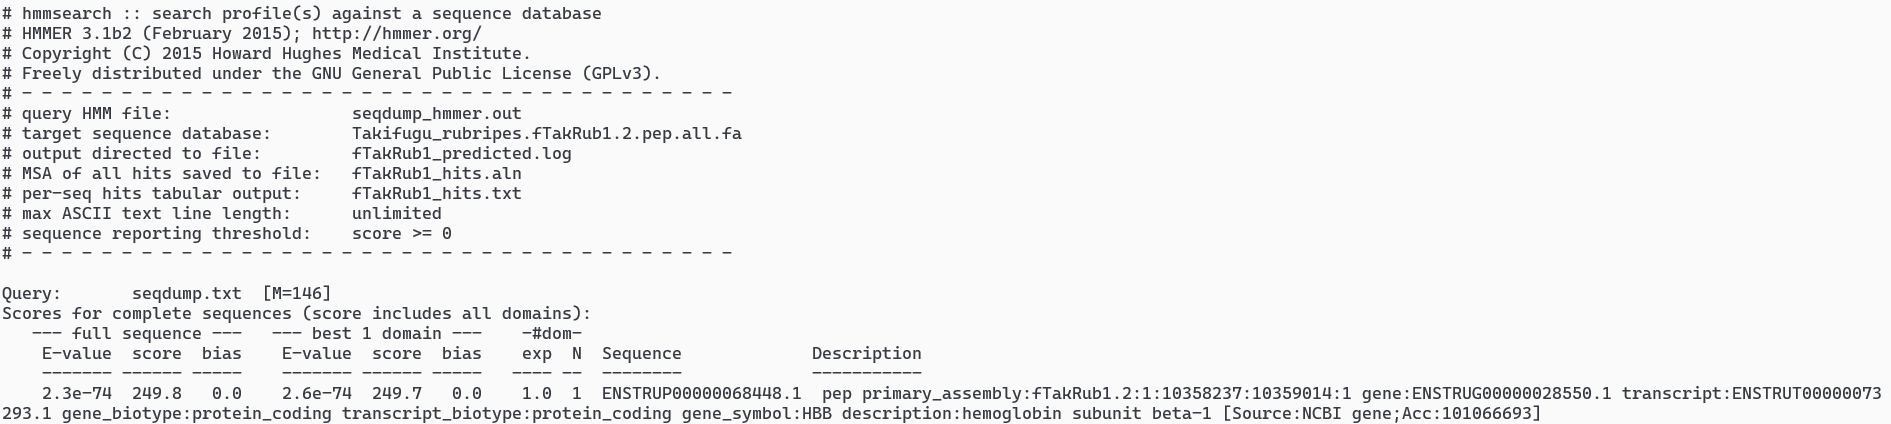



---


After hit table, the next section shows detailed annotations of the hit sequence, the best domain in the sequence, and the alignment between your sequence and the profile. Here, you can see three sets of coordinates: **1)** from and to with respect to the profile `hmmfrom` and `hmmto`; **2)** from and to in the alignment and with respect to your hit sequence; and **3)** from and to with respect to the "envelop". The envelop, which is usually wider than the alignment itself, defines the domain's location on the hit sequence and it incorporates the entire region that has a posterior probability to be a homologous domain, not just the alignment region. When the hit is significant and it has a high score, the envelop and the alignment will be the region and of the same width (or very similar). Otherwise, the envelop is wider. If you are extracting the region that is probably the domain homologue, it is best to use the envelop coordinates, since they incorporate the uncertainty around the domain's location.

---




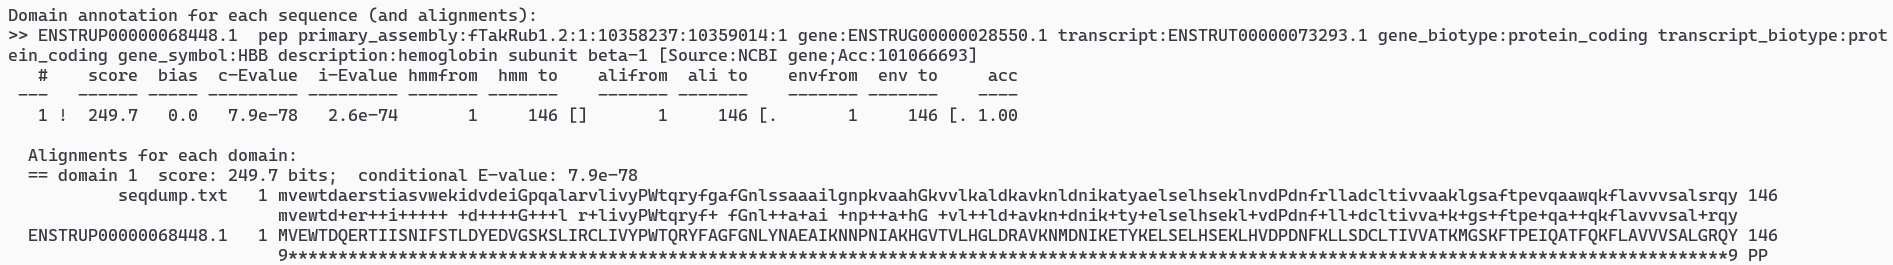

---



The last part of the file is a summary of the number of significant hits and other information of interest.



---


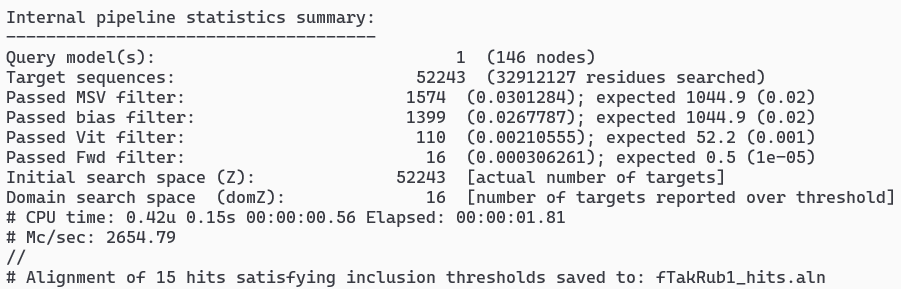


---
---

**Other things you can do with `hmmr` are:**

- Annotating one sequence using multiple profiles (`hmmbuild`, `hmmpress`, and `hmmscan`), instead of using a single profile to annotate multiple sequences (`hmmbuild` and `hmmsearch`)
- Produce statistics of the profile you create using `hmmstat`
- Create multiple sequence alignments using a profile as a guide (`hmmalign`). Very useful when you are trying to align very diverged homologues
- `hmmr` was designed to create protein profiles and search for those profiles in protein queries. However, it is possible to create DNA profiles to search entire DNA chromosomes, particularly if we are interested in the location of the features in the DNA sequences. That is possible using `nhmmer` and `nhmmrscan` and can be used to create profiles from publically available alignments.